**Danny Hong ECE-411 Final Project**

The following code implements a CNN-LSTM hybrid model for forecasting Adjusted Closing Stock Prices based on the paper: *A CNN-LSTM-Based Model to Forecast Stock Prices* by Wenjie Lu, Jiazheng Li, Yifan Li, Aijun Sun , and Jingyang Wang. Though many of model specifications of this implementation remained identical to what was defined by the authors in the paper, there are a few other differences between this procedure and the procedure done by the authors. 

1. The dataset used is different. Because the data used by the authors could not be found online, the datasets used for this project were all taken from Yahoo Finance and contain stock data for Apple, Amazon, JP Morgan & Chase, and Goldman Sachs from 2010-2017. 

2. There is no data normalization for this implementation. The paper applies a z-score data standardization process for both the model training and model prediction stages in order to normalize the stock prices based on distribution characteristics. However, because the results in the end for each of the four stocks are shown to be accurate enough, implementing a data normalization procedure on the data may not make much of a noticeable impact.

3. The data preprocessing step is different, which is due to the fact that the authors in their paper used a number of features to train the model (Multi-Dimensional). This project relies on analyzing the relative changes over time of only the Adjusted Closing Prices (1-Dimensional) time series data. The results of this will then be used to train the CNN part of the model to recognize the 'spatial' characteristics of the data. 

In [13]:
#!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, Flatten, MaxPooling1D, LSTM, TimeDistributed, Dense
from keras.optimizers import Adam

In [14]:
def get_stock_data(stock_name, start_date, end_date):
  print(str(stock_name) + " Stock Data:\n")
  stock_df = yf.download(stock_name, start_date, end_date).dropna()
  display(stock_df)
  print("\nTotal Number of Trading Days: ", len(stock_df))
  plt.plot(stock_df['Adj Close'])
  plt.title("Adjusted Close Stock Prices from 2010-2017 for " + str(stock_name))
  plt.xlabel("Time")
  plt.ylabel("Stock Prices")
  plt.show()

  return stock_df

AAPL Stock Data:

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.496294,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.507526,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.404016,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.392177,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.434674,447610800
...,...,...,...,...,...,...
2017-12-22,43.669998,43.855000,43.625000,43.752499,41.483433,65397600
2017-12-26,42.700001,42.867500,42.419998,42.642502,40.431000,132742000
2017-12-27,42.525002,42.695000,42.427502,42.650002,40.438110,85992800



Total Number of Trading Days:  2013


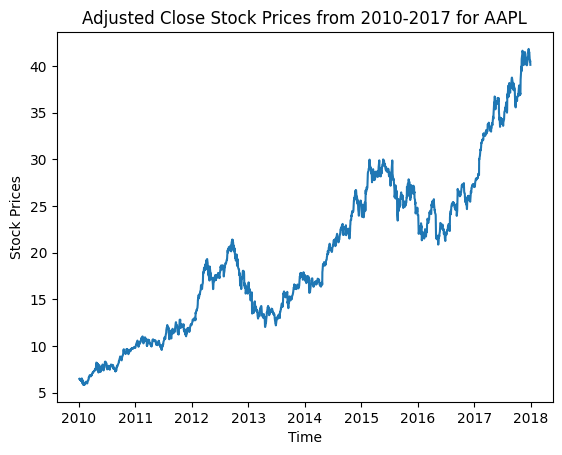

In [15]:
AAPL_stock_df = get_stock_data(stock_name = 'AAPL', start_date = '2010-01-01', end_date = '2018-01-01')

AMZN Stock Data:

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,6.812500,6.830500,6.657000,6.695000,6.695000,151998000
2010-01-05,6.671500,6.774000,6.590500,6.734500,6.734500,177038000
2010-01-06,6.730000,6.736500,6.582500,6.612500,6.612500,143576000
2010-01-07,6.600500,6.616000,6.440000,6.500000,6.500000,220604000
2010-01-08,6.528000,6.684000,6.451500,6.676000,6.676000,196610000
...,...,...,...,...,...,...
2017-12-22,58.604000,58.730999,58.391499,58.417999,58.417999,31702000
2017-12-26,58.417999,58.916000,58.027500,58.838001,58.838001,40104000
2017-12-27,58.995499,59.364498,58.780499,59.112999,59.112999,37344000



Total Number of Trading Days:  2013


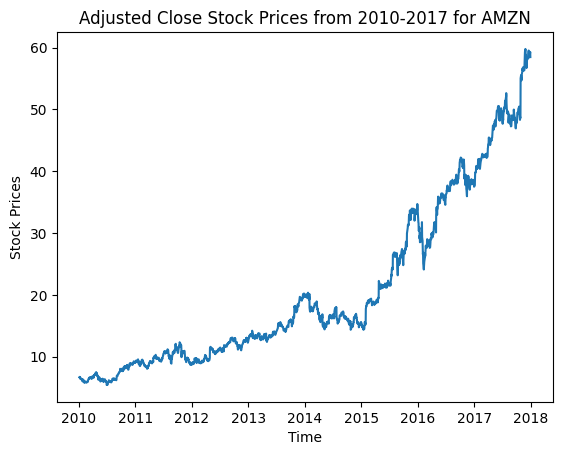

In [16]:
AMZN_stock_df = get_stock_data(stock_name = 'AMZN', start_date = '2010-01-01', end_date = '2018-01-01')

JPM Stock Data:

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,41.790001,42.990002,41.669998,42.849998,30.279612,35460500
2010-01-05,42.790001,43.840000,42.779999,43.680000,30.866125,41208300
2010-01-06,43.450001,44.090000,43.310001,43.919998,31.035702,27729000
2010-01-07,43.790001,45.119999,43.610001,44.790001,31.650492,44864700
2010-01-08,44.369999,44.700001,44.080002,44.680000,31.572758,33110100
...,...,...,...,...,...,...
2017-12-22,108.199997,108.459999,106.809998,107.449997,91.551704,14573400
2017-12-26,107.199997,107.989998,106.400002,107.019997,91.185326,7403700
2017-12-27,106.669998,107.290001,106.669998,107.220001,91.355751,9496500



Total Number of Trading Days:  2013


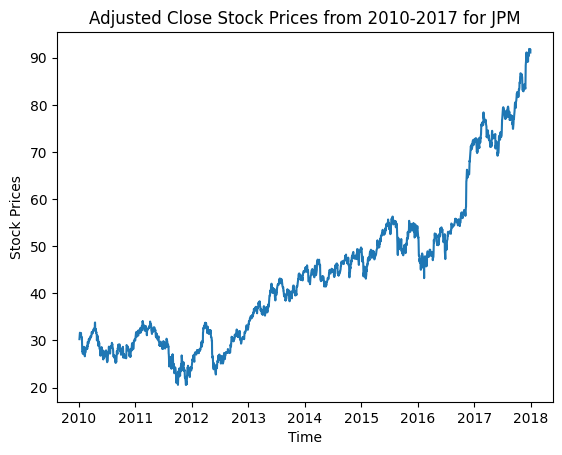

In [17]:
JPM_stock_df = get_stock_data(stock_name = 'JPM', start_date = '2010-01-01', end_date = '2018-01-01')

GS Stock Data:

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,170.050003,174.250000,169.509995,173.080002,139.862885,9135000
2010-01-05,173.000000,176.259995,172.570007,176.139999,142.335556,11659400
2010-01-06,175.380005,175.380005,173.759995,174.259995,140.816406,7381100
2010-01-07,174.320007,178.750000,173.949997,177.669998,143.572006,8727400
2010-01-08,176.330002,177.429993,173.949997,174.309998,140.856827,7268100
...,...,...,...,...,...,...
2017-12-22,261.660004,262.140015,257.720001,258.970001,232.350739,2100600
2017-12-26,258.190002,259.200012,256.000000,257.720001,231.229218,1289300
2017-12-27,257.980011,257.980011,255.520004,255.949997,229.641144,1567900



Total Number of Trading Days:  2013


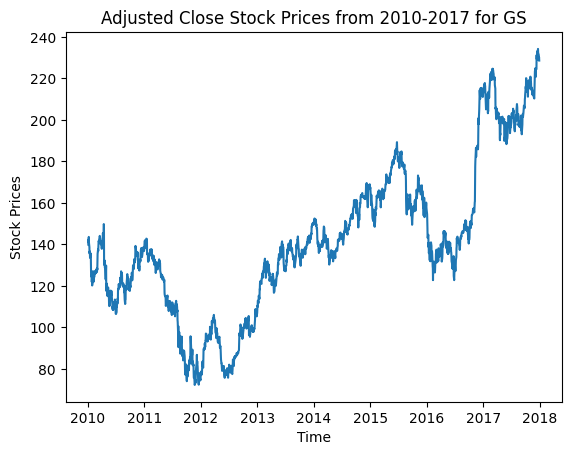

In [18]:
GS_stock_df = get_stock_data(stock_name = 'GS', start_date = '2010-01-01', end_date = '2018-01-01')

In [19]:
def CNN_LSTM(stock_df, stock_name):
  print('Running the Model for the ' + str(stock_name) + ' Data:\n')
  timesteps = 10
  X = []
  Y = []
  for i in range(0 , len(stock_df) - timesteps - 1 , 1):
    temp = []
    temp2 = []
    for j in range(timesteps):
      temp.append((stock_df.iloc[i + j, 4] - stock_df.iloc[i, 4]) / stock_df.iloc[i, 4])
    temp2.append((stock_df.iloc[i + timesteps, 4] - stock_df.iloc[i, 4]) / stock_df.iloc[i, 4])

    X.append(np.array(temp).reshape(timesteps, 1))
    Y.append(np.array(temp2).reshape(1, 1))

  train_X, test_X, train_label, test_label = train_test_split(X, Y, test_size = 0.1, shuffle = False)

  train_X = np.array(train_X)
  test_X = np.array(test_X)

  train_X = train_X.reshape(train_X.shape[0], 1, timesteps, 1)
  test_X = test_X.reshape(test_X.shape[0], 1, timesteps, 1)

  train_label = np.array(train_label)
  test_label = np.array(test_label)

  print("------------------------------------------------------------------------------------------")
  print("Length of Training Set: ", len(train_X))
  print("Length of Testing Set: ", len(test_X))
  print("------------------------------------------------------------------------------------------")

  print("\nTraining Step:")
  print("------------------------------------------------------------------------------------------")
  
  model = Sequential()

  model.add(TimeDistributed(Conv1D(filters = 32, kernel_size = 1, activation = 'tanh', padding = 'same', input_shape = (None, timesteps, 1))))
  model.add(TimeDistributed(MaxPooling1D(pool_size = 1, padding = 'same')))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(units = 64, activation = 'tanh', return_sequences = True))
  model.add(Dense(units = 1, activation = 'linear'))

  adam = Adam(learning_rate = 0.001)
  model.compile(optimizer = adam, loss = 'mean_absolute_error')

  model.fit(train_X, train_label, validation_data = (test_X, test_label), epochs = 100, batch_size = 64, shuffle = False, verbose = 1)

  score = model.evaluate(test_X, test_label, verbose = 0)
  print('\nTest loss:', score)
  print("------------------------------------------------------------------------------------------")

  print("\nPrediction Step:")
  print("------------------------------------------------------------------------------------------")
  predictions  = model.predict(test_X)
  print("------------------------------------------------------------------------------------------\n")
  test_label = (test_label[:, 0])
  predictions = np.array(predictions[:, 0]).reshape(-1, 1)

  for k in range(len(train_X) , len(train_X) + len(test_X)):
    test_label[k - len(train_X)] = (test_label[k - len(train_X)] * stock_df.iloc[k, 4]) + stock_df.iloc[k, 4]
    predictions[k - len(train_X)] = (predictions[k - len(train_X)] * stock_df.iloc[k, 4]) + stock_df.iloc[k, 4]

  predict_length = len(predictions)
  test_length = len(test_label)

  plt.figure(figsize = (10, 5))
  plt.plot(stock_df.index[-len(predictions):], predictions)
  plt.plot(stock_df.index[-len(test_label):], test_label)
  plt.title('Adjusted Close Stock Price Predictions for ' + str(stock_name))
  plt.xlabel('Time')
  plt.ylabel('Stock Price')
  plt.legend(['Predicted', 'Actual'])

  plt.show()

  return score

Running the Model for the AAPL Data:

------------------------------------------------------------------------------------------
Length of Training Set:  1801
Length of Testing Set:  201
------------------------------------------------------------------------------------------

Training Step:
------------------------------------------------------------------------------------------
Epoch 1/100
29/29 [==============================] - 3s 22ms/step - loss: 0.0231 - val_loss: 0.0110
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0151 - val_loss: 0.0093
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0135 - val_loss: 0.0086
Epoch 4/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0126 - val_loss: 0.0087
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.0087
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0123 - val_loss: 0.0085
Epoch 7/100
29/29 [=

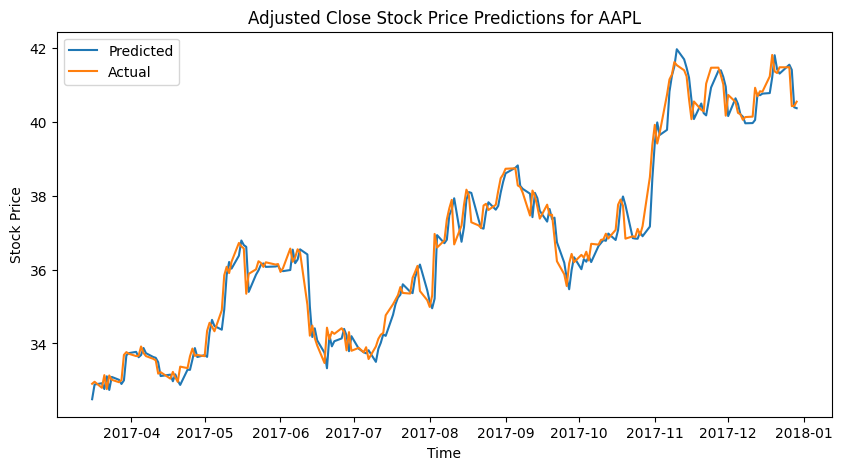

In [20]:
AAPL_score = CNN_LSTM(stock_df = AAPL_stock_df, stock_name = "AAPL")

Running the Model for the AMZN Data:

------------------------------------------------------------------------------------------
Length of Training Set:  1801
Length of Testing Set:  201
------------------------------------------------------------------------------------------

Training Step:
------------------------------------------------------------------------------------------
Epoch 1/100
29/29 [==============================] - 3s 22ms/step - loss: 0.0261 - val_loss: 0.0124
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0174 - val_loss: 0.0104
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0098
Epoch 4/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0147 - val_loss: 0.0094
Epoch 5/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.0094
Epoch 6/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.0091
Epoch 7/100
29/29 [=

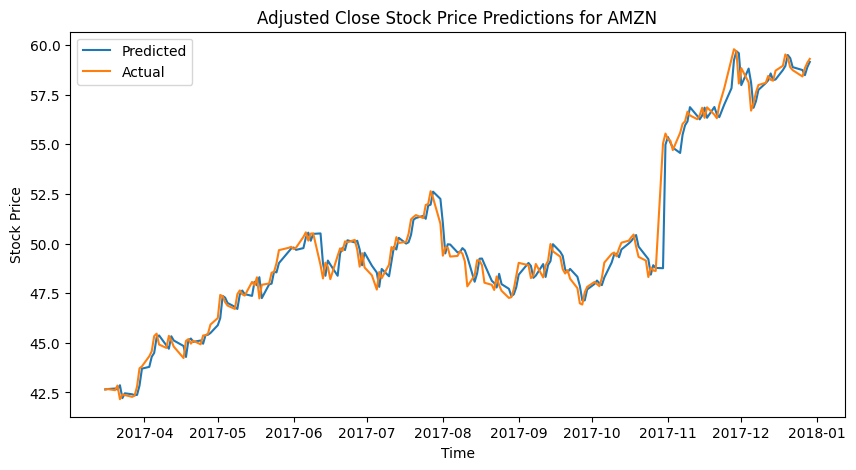

In [21]:
AMZN_score = CNN_LSTM(stock_df = AMZN_stock_df, stock_name = "AMZN")

Running the Model for the JPM Data:

------------------------------------------------------------------------------------------
Length of Training Set:  1801
Length of Testing Set:  201
------------------------------------------------------------------------------------------

Training Step:
------------------------------------------------------------------------------------------
Epoch 1/100
29/29 [==============================] - 2s 21ms/step - loss: 0.0239 - val_loss: 0.0113
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0152 - val_loss: 0.0091
Epoch 3/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0132 - val_loss: 0.0083
Epoch 4/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0126 - val_loss: 0.0081
Epoch 5/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0124 - val_loss: 0.0079
Epoch 6/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.0078
Epoch 7/100
29/29 [==

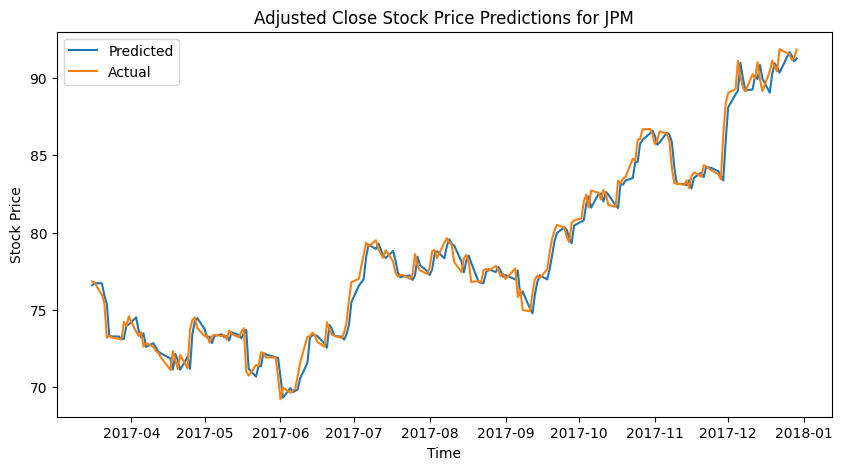

In [22]:
JPM_score = CNN_LSTM(stock_df = JPM_stock_df, stock_name = "JPM")

Running the Model for the GS Data:

------------------------------------------------------------------------------------------
Length of Training Set:  1801
Length of Testing Set:  201
------------------------------------------------------------------------------------------

Training Step:
------------------------------------------------------------------------------------------
Epoch 1/100
29/29 [==============================] - 2s 21ms/step - loss: 0.0245 - val_loss: 0.0125
Epoch 2/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0157 - val_loss: 0.0111
Epoch 3/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0136 - val_loss: 0.0102
Epoch 4/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0130 - val_loss: 0.0097
Epoch 5/100
29/29 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0095
Epoch 6/100
29/29 [==============================] - 0s 5ms/step - loss: 0.0125 - val_loss: 0.0096
Epoch 7/100
29/29 [===

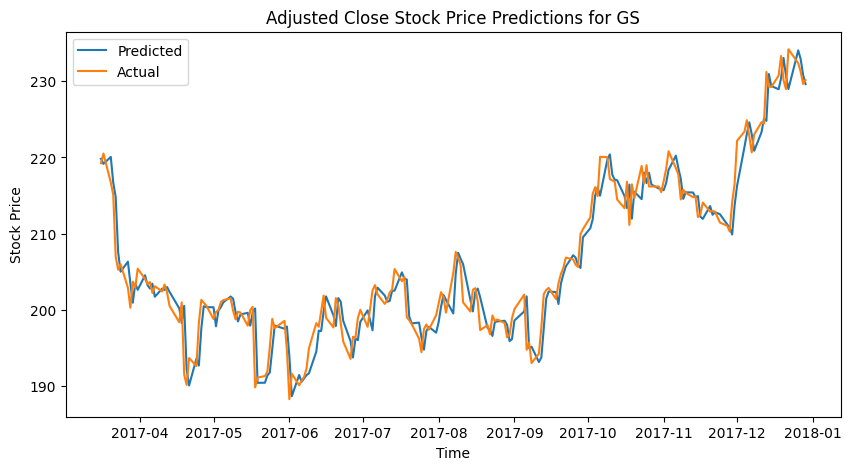

In [23]:
GS_score = CNN_LSTM(stock_df = GS_stock_df, stock_name = "GS")

In [24]:
stocks = ["AAPL", "AMZN" "JPM", "GS"]
test_losses = [AAPL_score, AMZN_score, JPM_score, GS_score]

test_losses_df = pd.DataFrame()
test_losses_df["Stocks"] = ["AAPL", "AMZN", "JPM", "GS"]
test_losses_df["Test Loss Values"] = [AAPL_score, AMZN_score, JPM_score, GS_score]

print("CNN-LSTM Model Test Loss Scores From Training:")
display(test_losses_df)

CNN-LSTM Model Test Loss Scores From Training:


,Stocks,Test Loss Values
0,AAPL,0.008403
1,AMZN,0.008936
2,JPM,0.007503
3,GS,0.009324
